# Housing prices for King County

Training a simple polynomial model on Hosing Sale data from king country [data source](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction)
As a learning exercise

In [2]:
from utils import load_data
from train import compute_cost, compute_gradient, gradient_descent
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# Data is a pandas DataFrame
data = load_data.load_data("./data/kc_house_data.csv")


# Feature Engineering
Housing prices do not tend to be linear but curve like, thus we will be engineering some polynomial features

In [3]:
labels = data['price']
data.drop(['price', 'date', 'id', 'lat', 'long'], axis=1, inplace=True)
dataSquared = data.pow(2)
dataSquared.rename(lambda c: f"{c} squared", inplace=True, axis='columns')

dataCubed = data.pow(3)
dataCubed.rename(lambda c: f"{c} cubed", inplace=True, axis='columns')

engineeredData = data.join(dataSquared).join(dataCubed)

engineeredData[0:5]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,view cubed,condition cubed,grade cubed,sqft_above cubed,sqft_basement cubed,yr_built cubed,yr_renovated cubed,zipcode cubed,sqft_living15 cubed,sqft_lot15 cubed
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,0,27,343,1643032000,0,7472058875,0,946329856735752,2406104000,180362125000
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,0,27,343,10218313000,64000000,7426288351,7892485271,944798095703125,4826809000,445768658119
2,2,1.00,770,10000,1.0,0,0,3,6,770,...,0,27,216,456533000,0,7222633237,0,941998966517952,20123648000,523996494328
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,0,125,343,1157625000,753571000,7587307125,0,945115872339456,2515456000,125000000000
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,0,27,512,4741632000,0,7845011803,0,943325698349224,5832000000,422381452527


# Training Data
We have split the data into two halves, the first half will be the training data. Matrix trainingSamples contains our examples. Each row is an example and each column is a feature. Vector trainingLabels contains the labels for our training set.

In [4]:
total_rows = len(engineeredData)
trainingSetRows = total_rows // 2
trainingSamples = engineeredData[0:trainingSetRows].copy()
trainingLabels = labels[0:trainingSetRows].copy()

print(f"trainingSamples shape: {trainingSamples.shape}")
print(f"trainingLabels shape: {trainingLabels.shape}")

trainingSamples shape: (10806, 48)
trainingLabels shape: (10806,)


# Feature Scaling


In [5]:
means = engineeredData.mean()
stds = engineeredData.std()
print(engineeredData[:5])
for column in engineeredData.columns:
    engineeredData[column] = engineeredData[column] - means[column]
    engineeredData[column] = engineeredData[column] / stds[column]
print(engineeredData[:5])

   bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0         3       1.00         1180      5650     1.0           0     0   
1         3       2.25         2570      7242     2.0           0     0   
2         2       1.00          770     10000     1.0           0     0   
3         4       3.00         1960      5000     1.0           0     0   
4         3       2.00         1680      8080     1.0           0     0   

   condition  grade  sqft_above  ...  view cubed  condition cubed  \
0          3      7        1180  ...           0               27   
1          3      7        2170  ...           0               27   
2          3      6         770  ...           0               27   
3          5      7        1050  ...           0              125   
4          3      8        1680  ...           0               27   

   grade cubed  sqft_above cubed  sqft_basement cubed  yr_built cubed  \
0          343        1643032000                    0      74

# Parameters
Parameter vector w and param b


In [8]:
b = 1
w = np.random.random_sample(trainingSamples.shape[1])
print(f"w shape: {w.shape}")
print(f"Initial cost: {compute_cost(trainingSamples.to_numpy(), trainingLabels.to_numpy(), w, b)}")
dj_dw, dj_db = compute_gradient(trainingSamples.to_numpy(), trainingLabels.to_numpy(), w, b)
print(f"Initial gradient dw:  {dj_dw})")
print(f"Initial gradient db: {dj_db})")

w shape: (48,)
Initial cost: 5.818350058343597e+30
Initial gradient dw:  [7.56612191e+14 4.71781439e+14 5.01806698e+17 7.11362411e+19
 3.22039164e+14 1.74875110e+12 1.17672701e+14 7.64715449e+14
 1.70923667e+15 4.37981278e+17 6.38254198e+16 4.31802343e+17
 1.49053533e+16 2.15233121e+19 4.65368657e+17 2.02459286e+19
 2.78911711e+15 1.18513203e+15 1.42037266e+21 8.62522742e+25
 5.34163941e+14 1.74875110e+12 3.40787805e+14 2.76181387e+15
 1.38036371e+16 1.09006176e+21 7.13564487e+19 8.49732136e+20
 2.97576469e+19 2.11067061e+24 1.08230519e+21 8.49814760e+24
 1.08871375e+16 3.34036496e+15 4.84207787e+24 1.19657588e+32
 9.87053658e+14 1.74875110e+12 1.02220904e+15 1.03552794e+16
 1.15789318e+17 3.26462875e+24 9.79206475e+22 1.67258516e+24
 5.94127330e+22 2.06981694e+29 2.74265864e+24 4.88041573e+30])
Initial gradient db: 219481469401035.84)


In [7]:
# Run gradient descent
alpha = 5.0e-7
iterations = 1000
w_final, b_final, j_history = gradient_descent(trainingSamples.to_numpy(), trainingLabels.to_numpy(), w, b, compute_cost, compute_gradient, alpha, iterations)
print(f"Final cost: {compute_cost(trainingSamples.to_numpy(), trainingLabels.to_numpy(), w_final, b_final)}")


Iteration    0: Cost 588830421521532701135165054323984719067113855971729483348316007359883647363651509157888.00   


/home/ahi/PycharmProjects/HouseSalesKingCounty/train.py:24: RuntimeWarning: overflow encountered in scalar power
  cost += (f_wb - y[i]) ** 2
/home/ahi/PycharmProjects/HouseSalesKingCounty/train.py:47: RuntimeWarning: invalid value encountered in multiply
  dj_dw = dj_dw + error * X[i]


Iteration   10: Cost      inf   
Iteration   20: Cost      nan   
Iteration   30: Cost      nan   
Iteration   40: Cost      nan   
Iteration   50: Cost      nan   
Iteration   60: Cost      nan   
Iteration   70: Cost      nan   
Iteration   80: Cost      nan   
Iteration   90: Cost      nan   
Iteration  100: Cost      nan   
Iteration  110: Cost      nan   
Iteration  120: Cost      nan   
Iteration  130: Cost      nan   
Iteration  140: Cost      nan   
Iteration  150: Cost      nan   
Iteration  160: Cost      nan   
Iteration  170: Cost      nan   
Iteration  180: Cost      nan   
Iteration  190: Cost      nan   
Iteration  200: Cost      nan   
Iteration  210: Cost      nan   
Iteration  220: Cost      nan   
Iteration  230: Cost      nan   
Iteration  240: Cost      nan   
Iteration  250: Cost      nan   
Iteration  260: Cost      nan   
Iteration  270: Cost      nan   
Iteration  280: Cost      nan   
Iteration  290: Cost      nan   
Iteration  300: Cost      nan   
Iteration 

# Plotting cost vs iterations


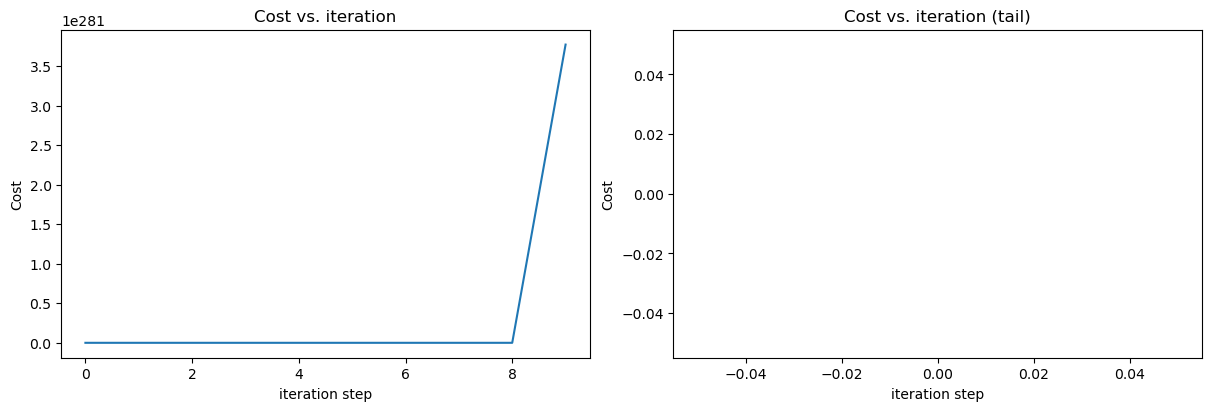

In [6]:


fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(j_history)
ax2.plot(100 + np.arange(len(j_history[100:])), j_history[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step')
plt.show()